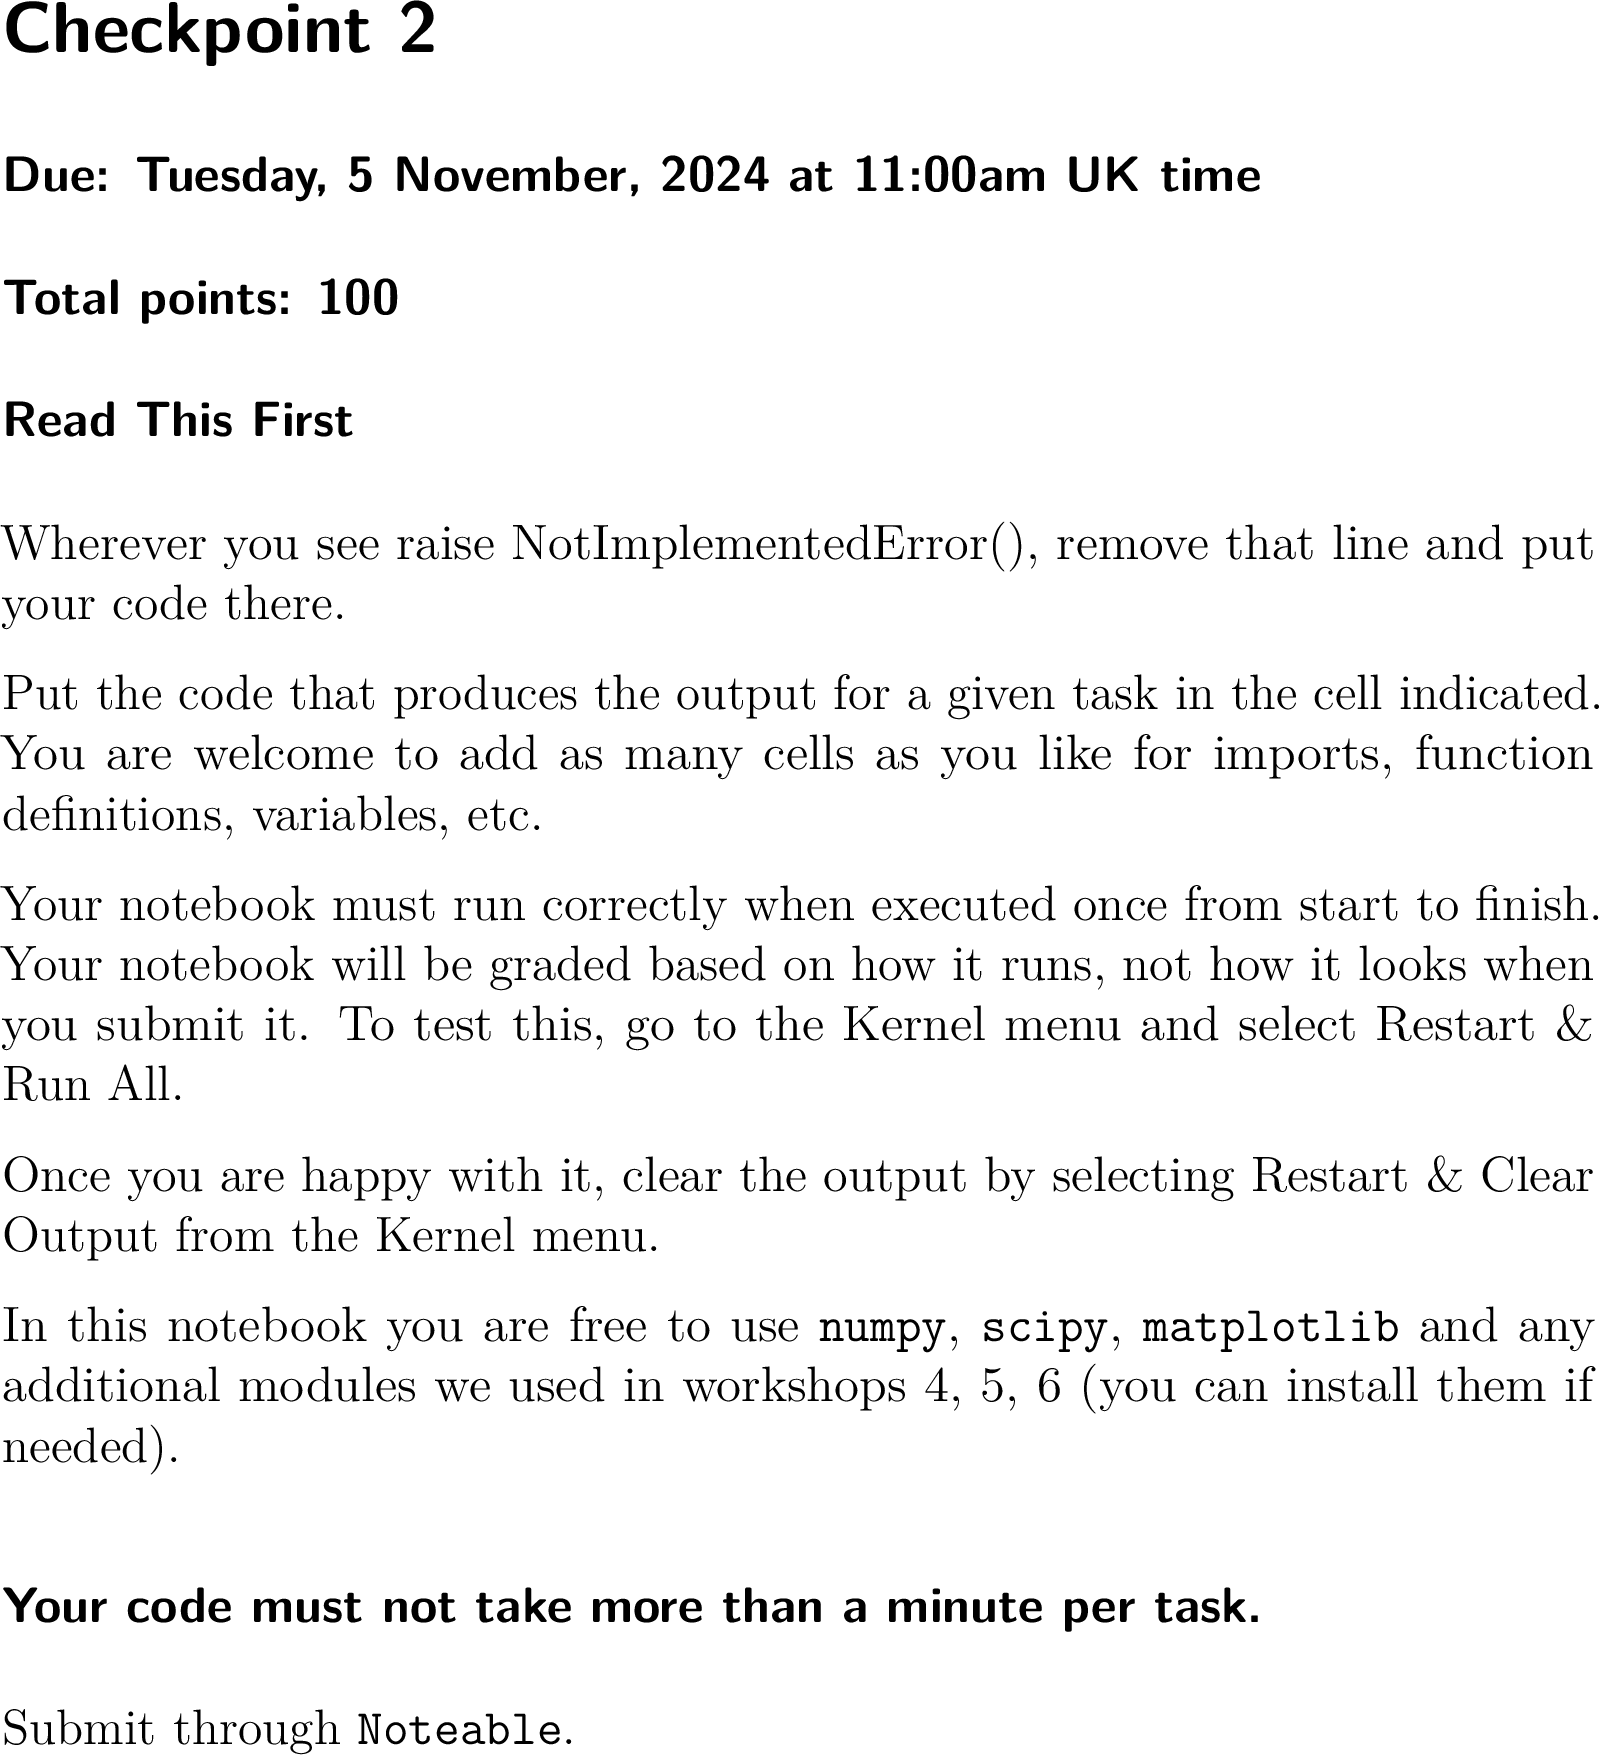

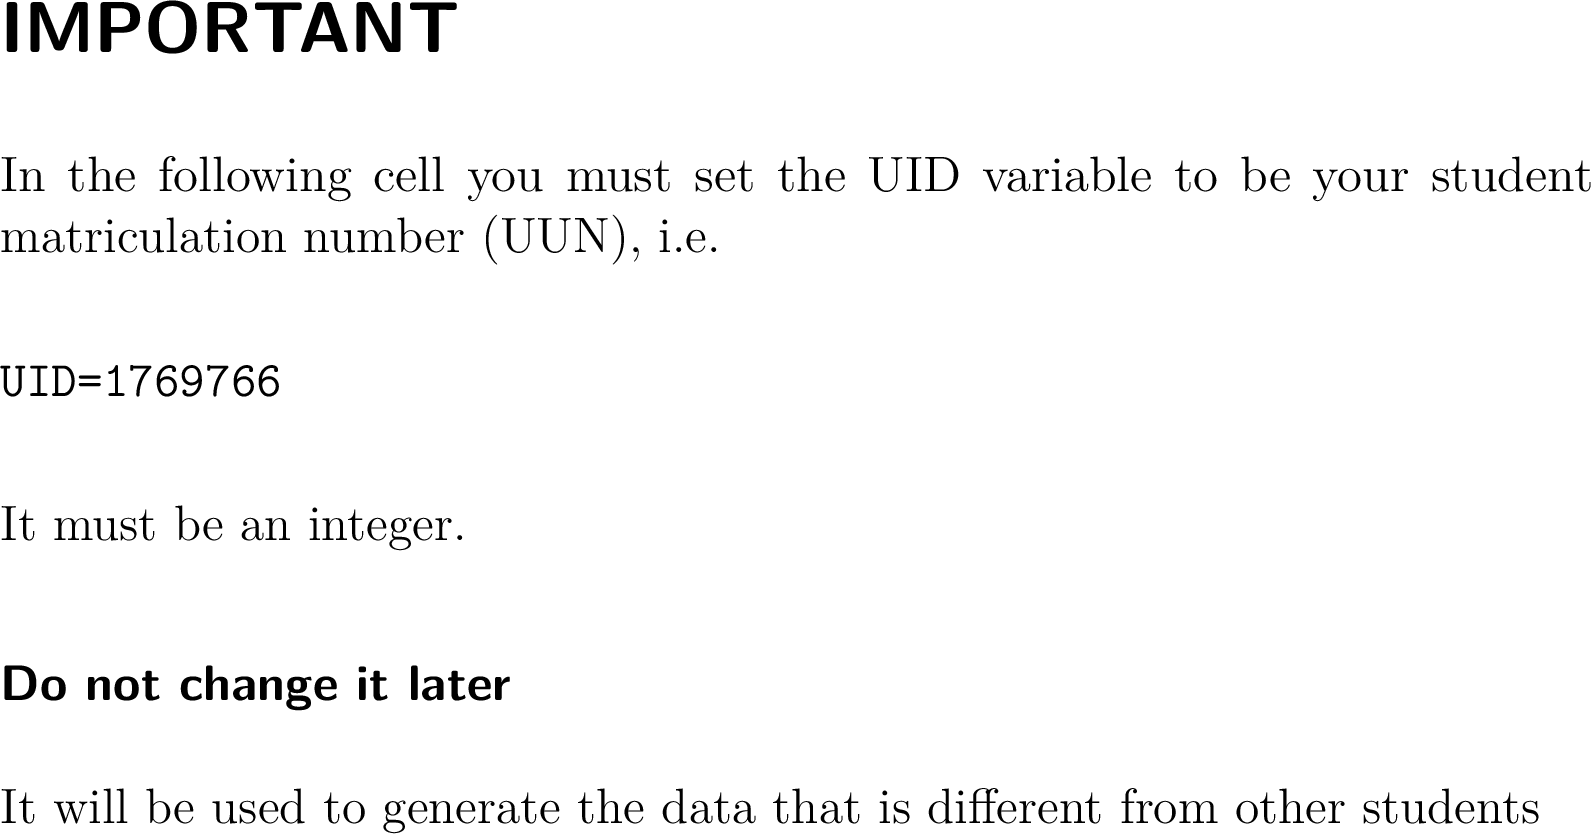

In [ ]:
UID = 2344216
# Checking it is integer
assert (type(UID) is int)

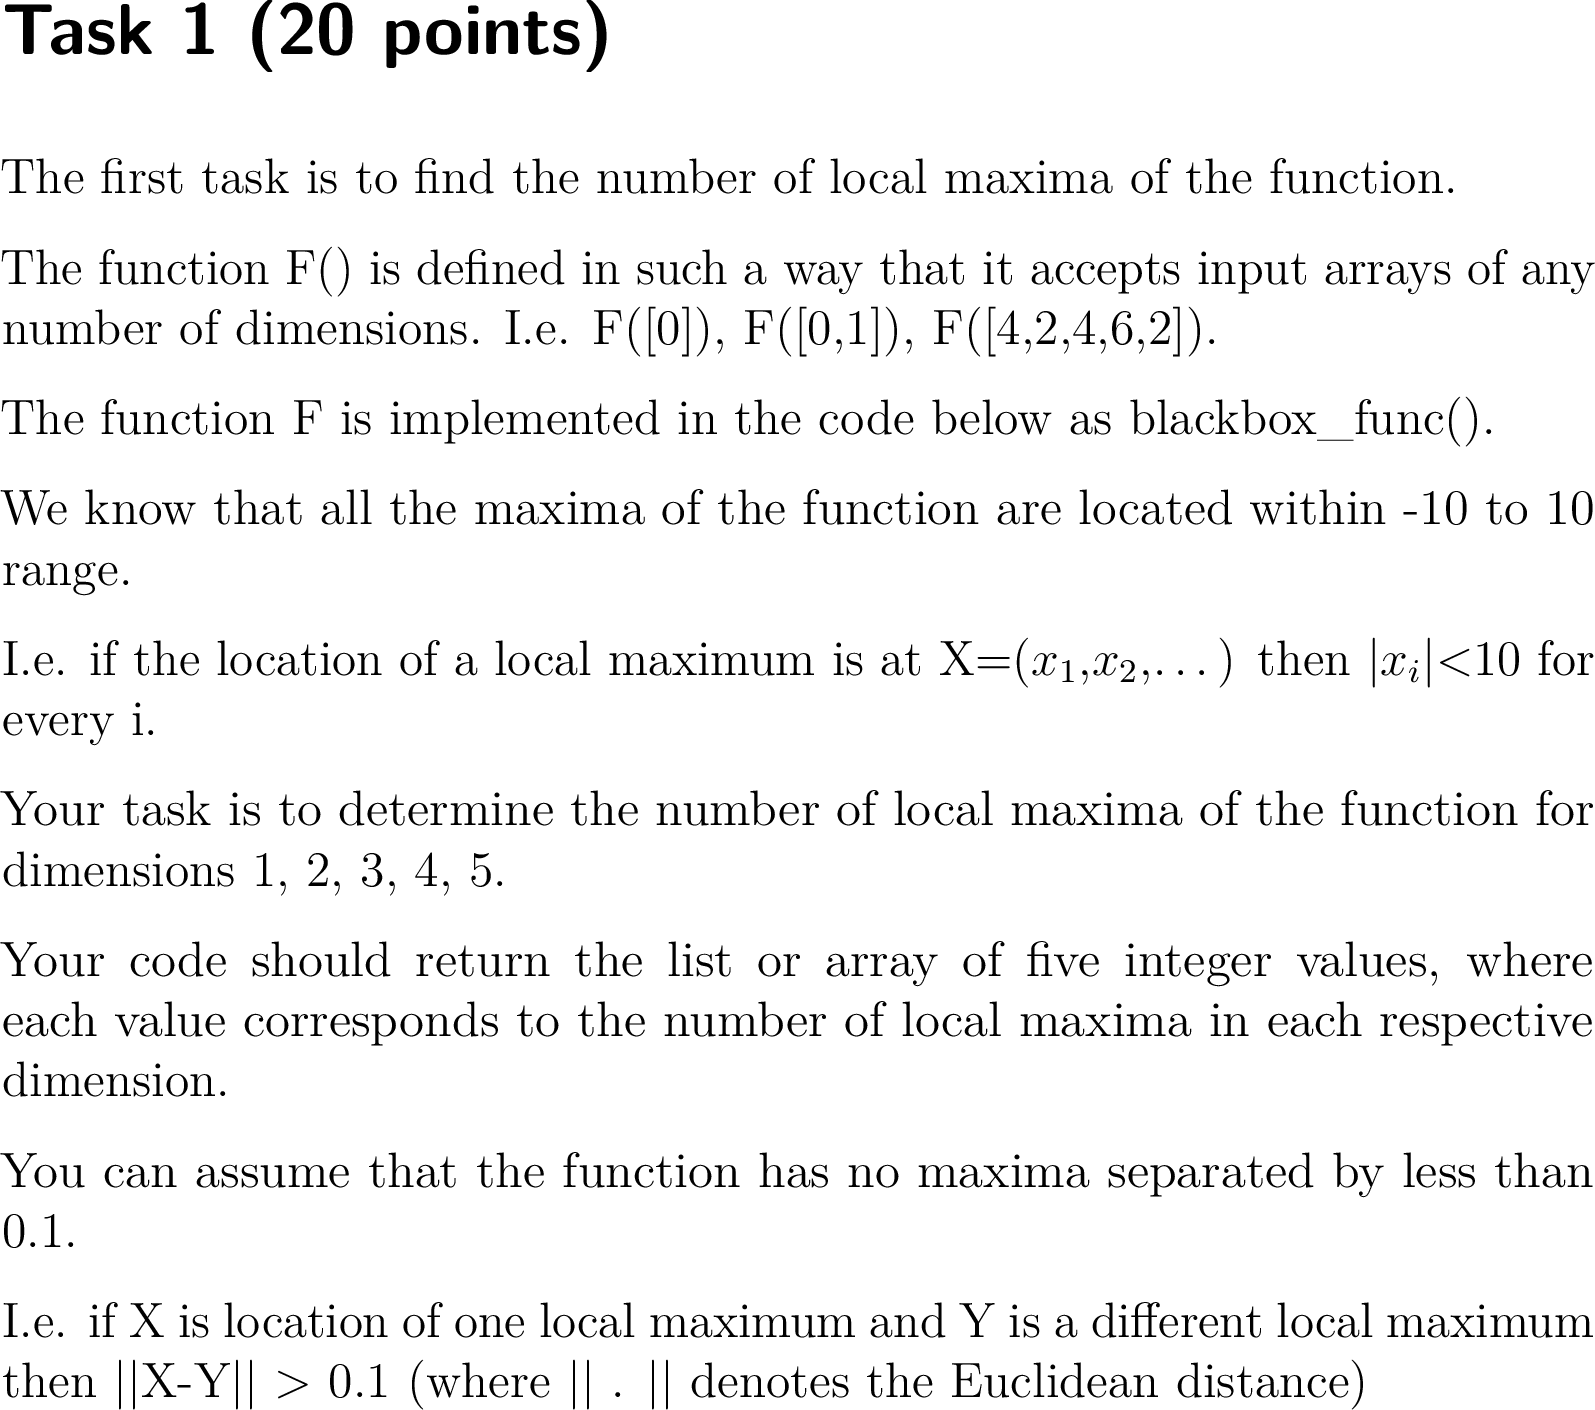

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.stats

%matplotlib inline

In [ ]:
!pip install numdifftools

In [ ]:
import time as t
from scipy.integrate import quad
import numdifftools

# Goals

- find number of maxima of function F() for x [-10, 10] in the dimensional spaces 1-5.
    - can take input of upto 5 dimensional vectors
    - defined as blackbox_func()
    - maxima are all located within a range of -10 to 10
    - return a list or array of five integer values where each value corresponds to the number of maxima in each dimension
    - maxima are seperated by at least 0.1
    
# Plan
- need to reflect function across the x-axis and minimise that function and that will give the maxima of the original function.
- multiply every xvalue by -1?

In [ ]:
T1_D = np.load("checkpoint2_task1.npz")["arr_0"]
dims = [1, 2, 3, 4, 5]
import scipy.special as ssp


def blackbox_func(p):
    """
    This is is the function that you need to optimize
    It takes vector arguments (of any length) and a returns a scalar
    """
    p = np.asarray(p)
    ndim = len(p)
    pos = dims.index(ndim)
    pos = np.random.default_rng(UID).permutation(5)[pos]
    curD = T1_D[1000 * pos : 1000 * (pos + 1), :ndim]
    return ssp.logsumexp(np.sum(-0.5 * ((p[None, :] - curD) / 0.3) ** 2, axis=1))


# The function is defined in  1,2,3,4,5 dimensions
print(blackbox_func([0]))
print(blackbox_func([0, 0]))
print(blackbox_func([0, 0, 0]))

In [ ]:
def find_number_of_maxima():
    """
    Your function should return the list or array of 5 integers
    """
    
    # Reflecting blackbox_func across x-axis to use minimization to find maxima
    reflected_func = lambda p: -1 * blackbox_func(p)
    
    # Initial random guess 
    rstate = np.random.default_rng(UID)
    unique_minimas_count = []
    
    # looping through random points in each dim to find minima
    for d in dims:
        num_guesses = 25 * d
        all_minima = np.zeros((num_guesses, d))
        
        #checking minima for multiple guesses
        for i in range(num_guesses):
            x0 = rstate.uniform(low=-10, high=10, size=d) 
            minima = scipy.optimize.minimize(reflected_func, x0, method='BFGS', tol=1e-4)
            all_minima[i] = minima.x
          
        # removing minima that are too close (double counted minima within 0.1) 
        unique_minima = []
        for point in all_minima:
            if all(np.linalg.norm(point - minima) >= 0.1 for minima in unique_minima):
                unique_minima.append(point)
                        
        unique_minimas_count.append(len(unique_minima))

    return unique_minimas_count

In [ ]:
my_maxima = find_number_of_maxima()
assert len(my_maxima) == 5
print(my_maxima)

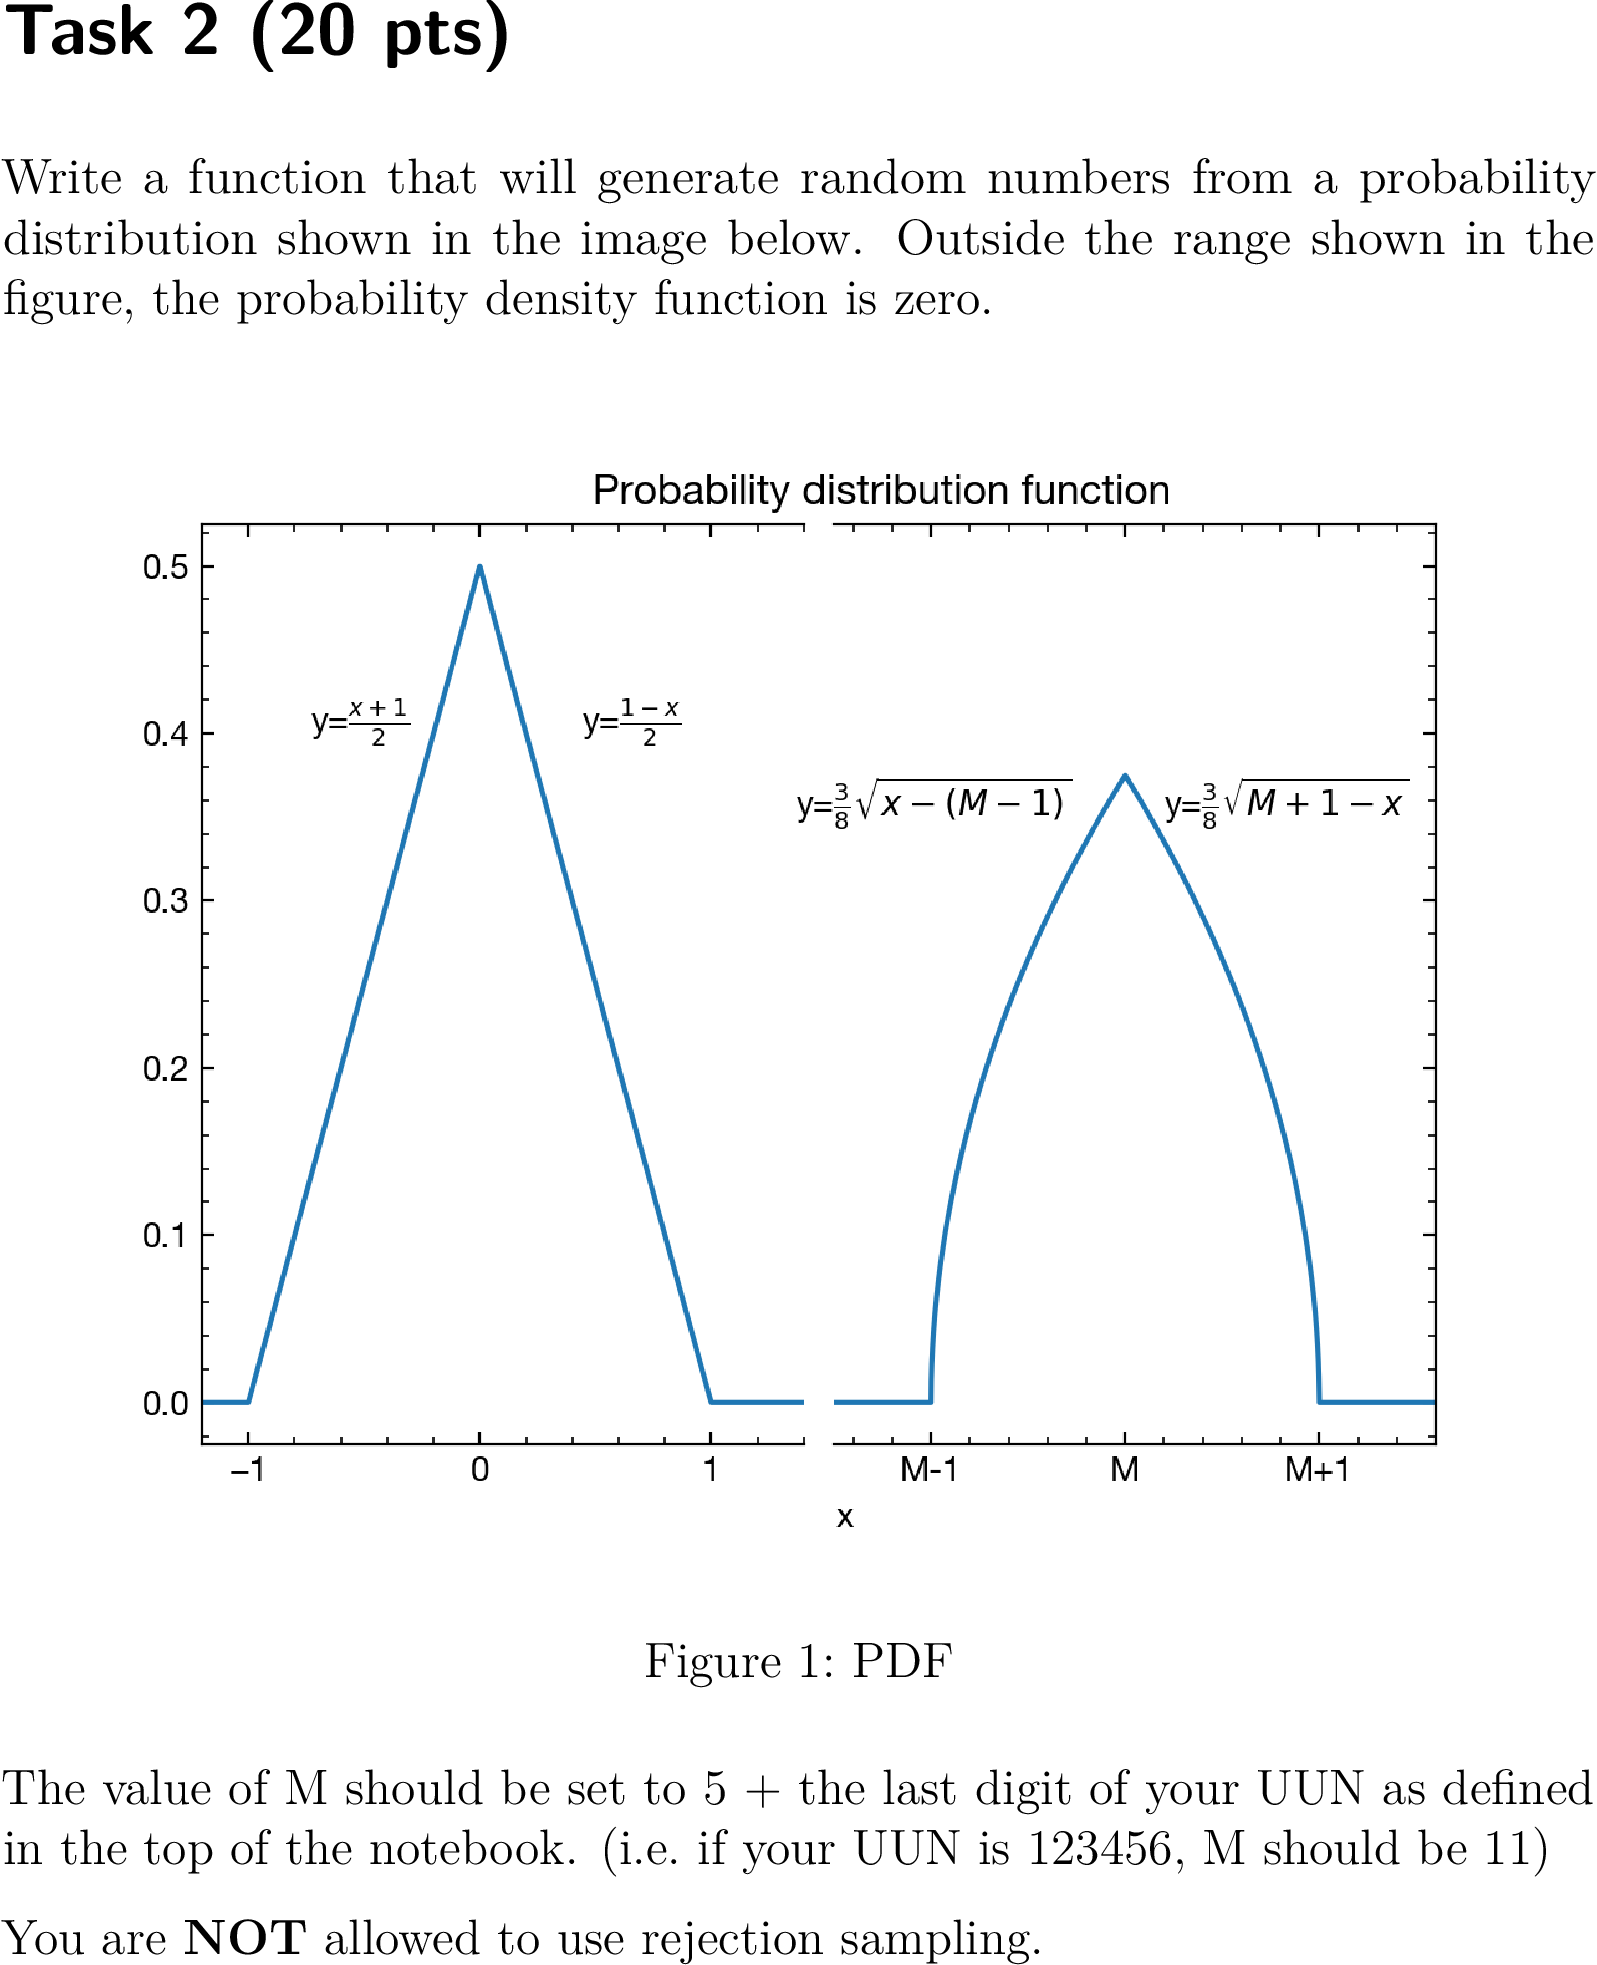

In [ ]:
M = (UID % 10) + 5

def inv_cdf(vals):
    """
    function was solved analytically and then bounds were inputted here- desmos was used to verify bounds
    """
    x = np.zeros_like(vals)
    
    # triangle pdf
    lower_bound_1 = (vals >= 0) & (vals <= 0.25)
    x[lower_bound_1] = -1 + np.sqrt(4 * vals[lower_bound_1])

    upper_bound_1 = (vals > 0.25) & (vals <= 0.5)
    x[upper_bound_1] = 1 - np.sqrt(2 - 4 * vals[upper_bound_1])
    
    # ovalish pdf
    lower_bound_2 = (vals > 0.5) & (vals <= 0.75)
    x[lower_bound_2] = (M - 1) + ((4 * vals[lower_bound_2] - 2) ** (2 / 3))

    upper_bound_2 = (vals > 0.75) & (vals <= 1)
    x[upper_bound_2] = (M + 1) - ((4 * (1 - vals[upper_bound_2])) ** (2 / 3))

    return x

def generate_samples(N):
    """
    Return a numpy array with N random numbers
    following the distribution specified
    """
    rstate = np.random.default_rng(UID)
    vals = rstate.uniform(size=N)
    x = inv_cdf(vals)
    return x

In [ ]:
# The code will be tested by this
# the distribution of points should look like a the image
task2_result = generate_samples(100000)
assert len(task2_result) == 100000
plt.hist(task2_result, bins=200, alpha=0.5)

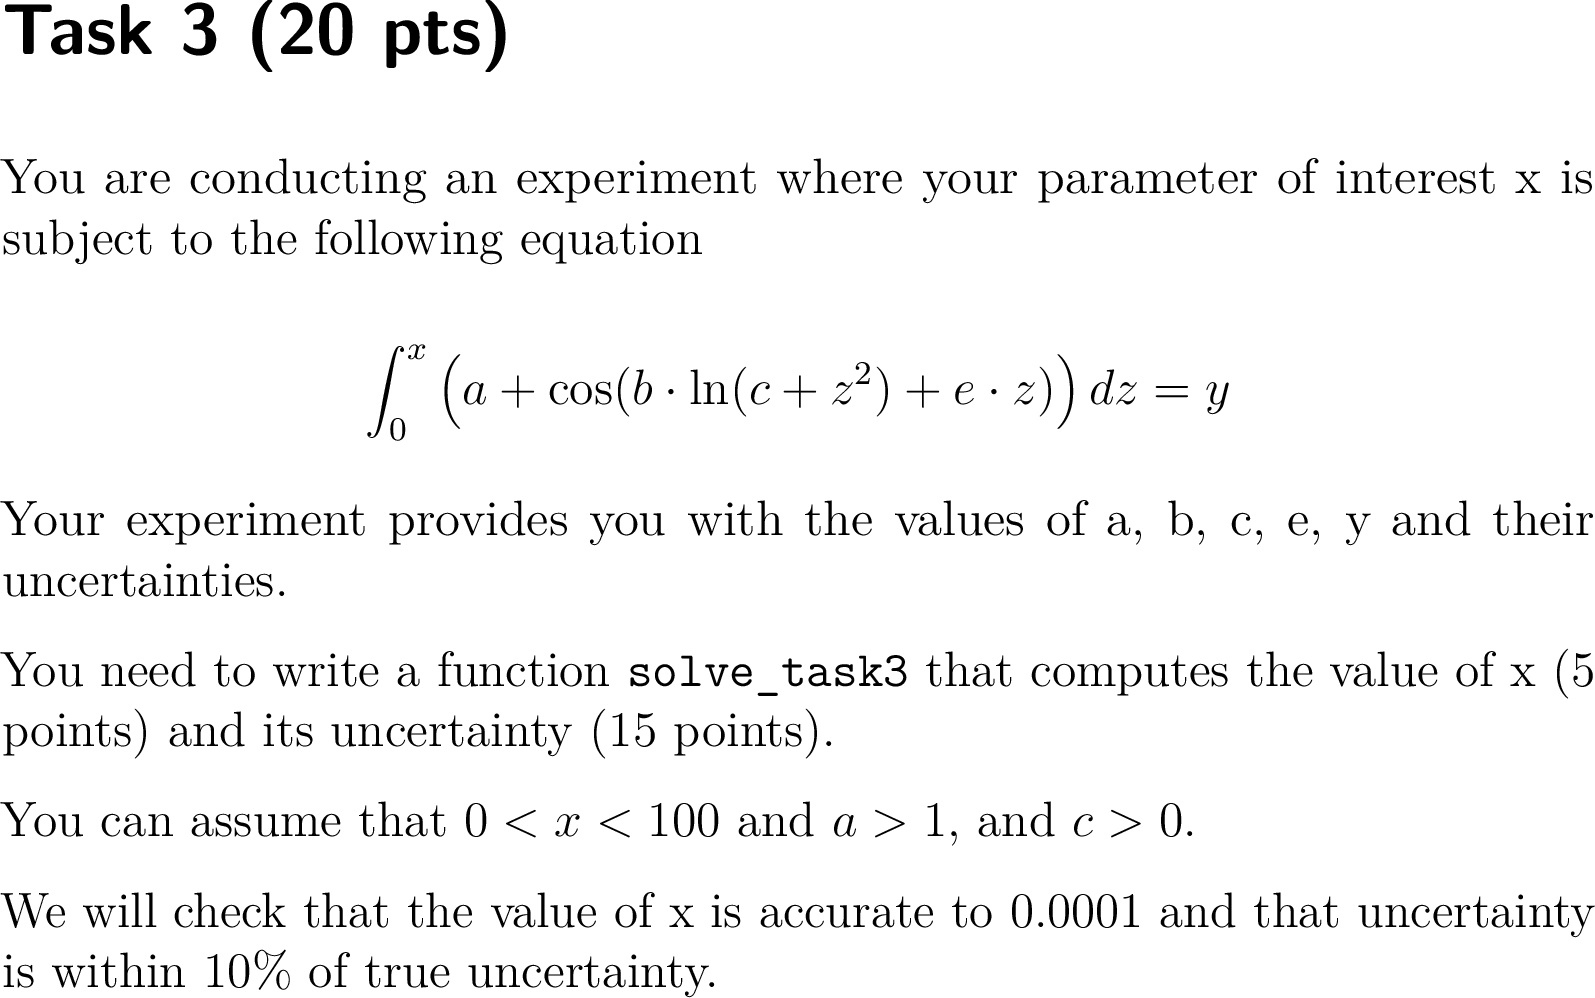

In [ ]:
def solve_task3(
    a=None,
    b=None,
    c=None,
    e=None,
    y=None,
    err_a=None,
    err_b=None,
    err_c=None,
    err_e=None,
    err_y=None,
):
    """
    This function will return two numbers x and its uncertainty given a, b, c, e, y values
    and their uncertainties
    """  
    # creating func to integrate 
    func = lambda z: a + np.cos(b * np.log(c + z**2) + e * z)
    
    #integrating func to have f(x) = 0 for root finding
    sol = lambda x: quad(func, 0, x)[0] - y 
    
    sol_x = scipy.optimize.brentq(sol, a=0, b=100)
    
    N = int(1e3)
    rstate = np.random.default_rng(UID)
    a_s = rstate.normal(a, err_a, size = N)
    b_s = rstate.normal(b, err_b, size = N)
    c_s = rstate.normal(c, err_c, size = N)
    e_s = rstate.normal(e, err_e, size = N)
    y_s = rstate.normal(y, err_y, size = N)

    x_2 = np.zeros(N)
    
    # monte carlo err calc
    for i in range(N):
        func_2 = lambda z: a_s[i] + np.cos(b_s[i] * np.log(c_s[i] + z**2) + e_s[i] * z)
        sol_2 = lambda x: quad(func_2, 0, x)[0] - y_s[i]
        x_2[i] = scipy.optimize.brentq(sol_2, a=0, b=100)
    
    err_x = x_2.std()

    return sol_x, err_x

In [ ]:
testme = solve_task3(a=3, b=1, c=0.2, e=0.4, y=5, err_a=0.2, err_b=0.2, err_c=0.02, err_e=0.1, err_y=0.2)
print(testme)
assert len(testme) == 2

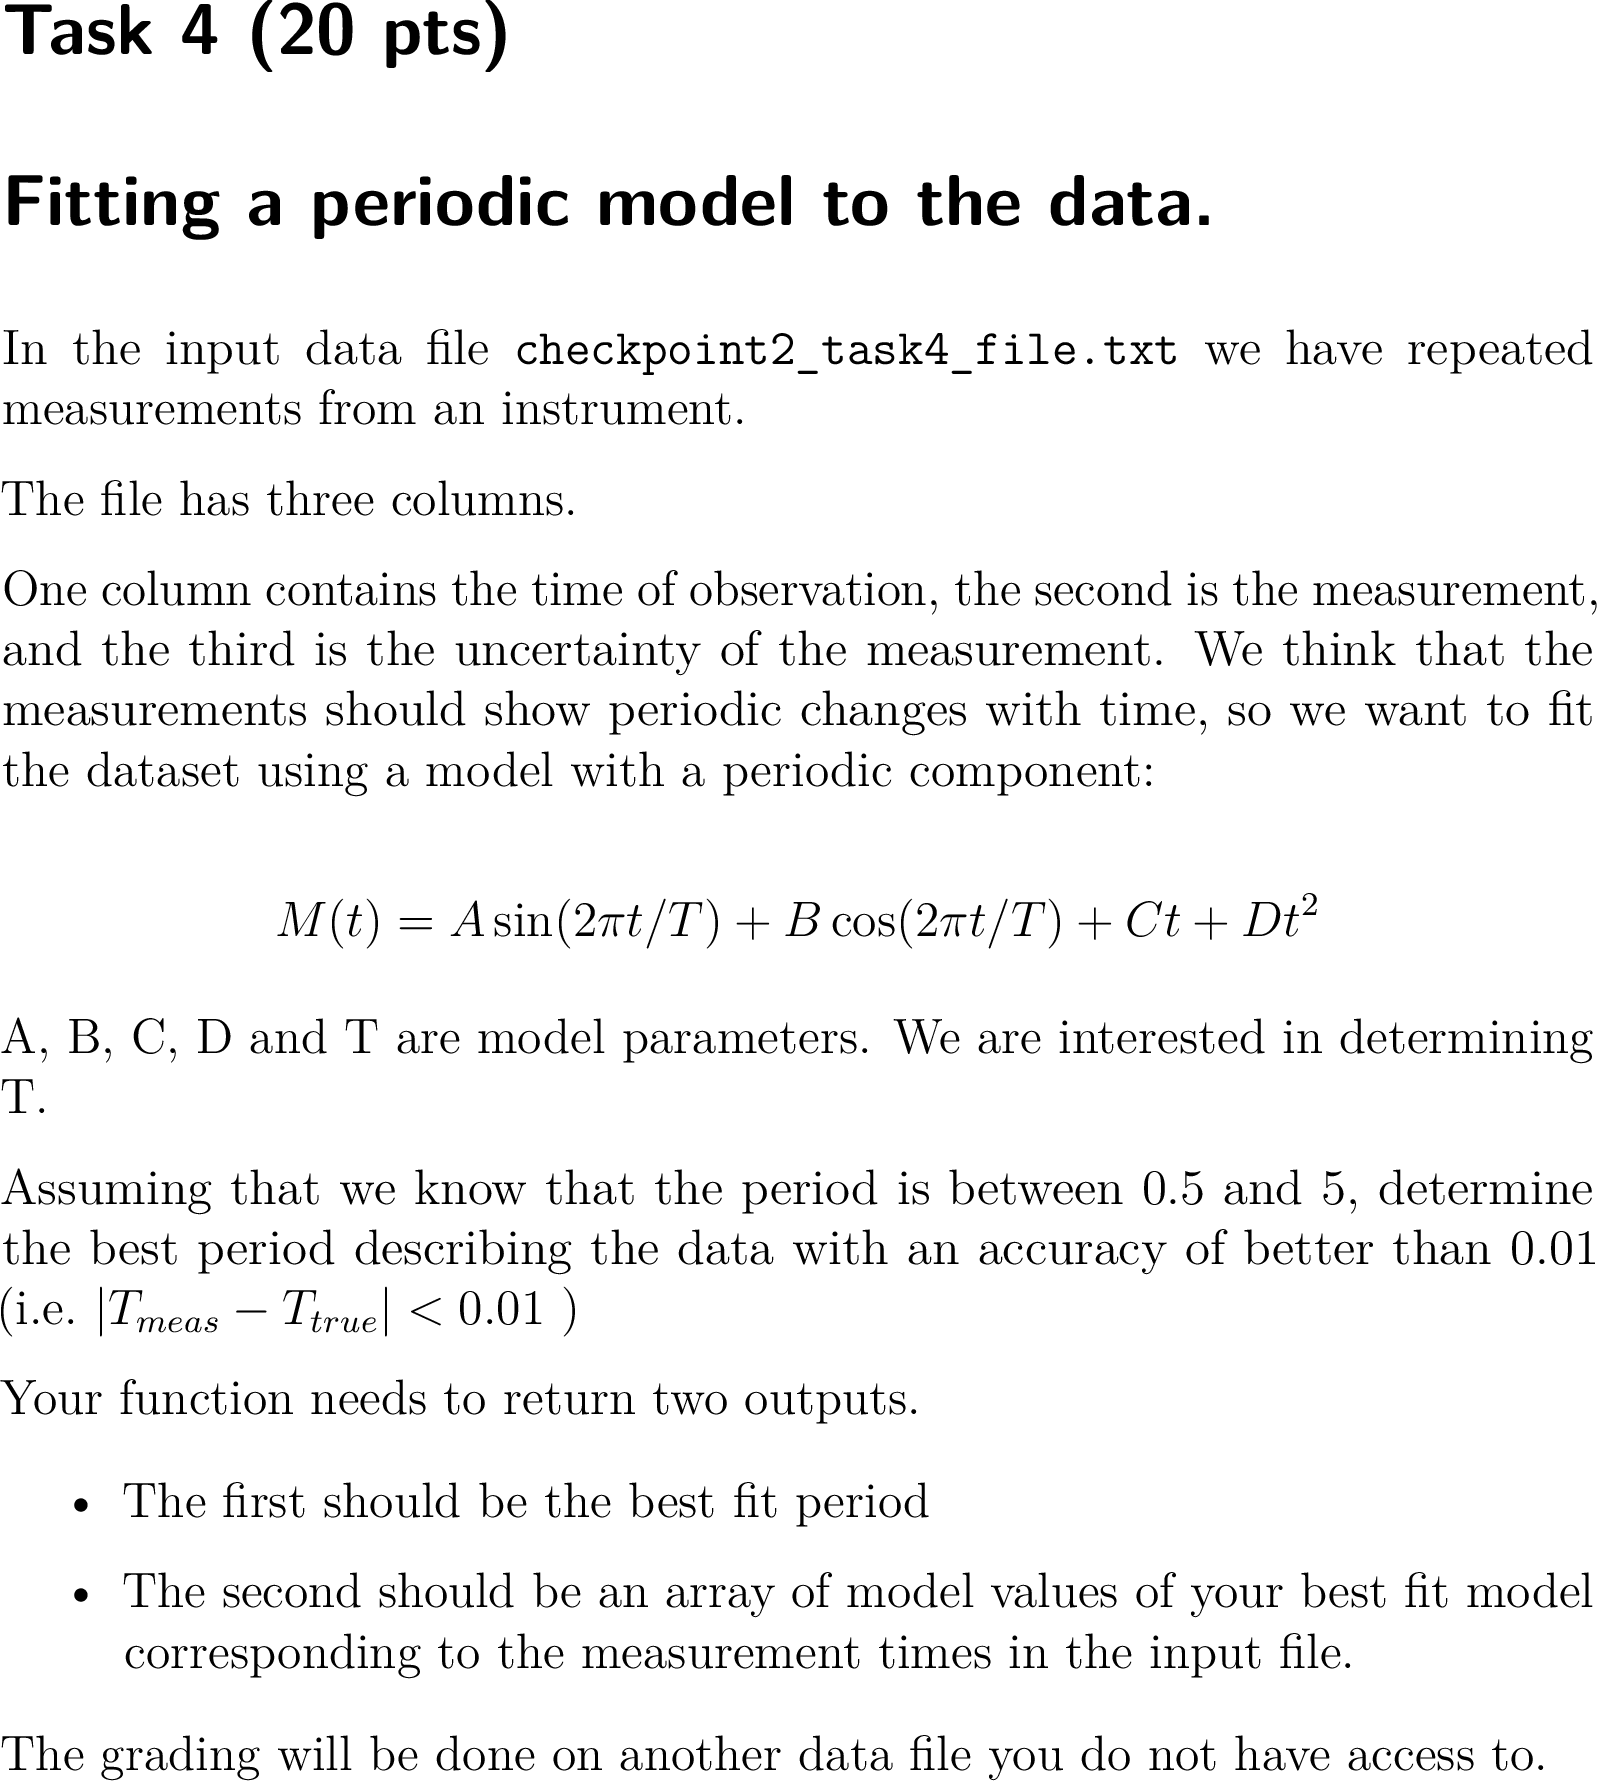

In [ ]:
def solve_period_model(filename):
    """
    This function should read the data from the file
    Fit the model and return the pair of best-fit period, best-fit model value array
    """
    DATA = np.loadtxt(filename)
    t, y, ey = DATA
    
    N = len(t)
    lowest_chi_square = float("inf")
    Tgrid = np.linspace(0.5, 5, 1000)
    
    for T in Tgrid:
        A = np.zeros((N, 4))
        
        # design matrix
        A[:, 0] = np.sin(2 * np.pi * t / T) / ey
        A[:, 1] = np.cos(2 * np.pi * t / T) / ey
        A[:, 2] = t / ey
        A[:, 3] = t**2 / ey
            
        res = np.linalg.lstsq(A, y/ey, rcond = None)
    
        #model = (res[0][0] * np.sin(2 * np.pi * t / T) + 
        #         res[0][1] * np.cos(2 * np.pi * t / T) + 
        #         res[0][2] * t + 
        #         res[0][3] * t**2)
        
        model = A @ res[0]
        
        chi_square = res[1]
        
        #best/lowest chisquare
        if chi_square < lowest_chi_square:
            lowest_chi_square = chi_square
            best_T = T
            best_params = res[0]
        
    # best_y_model = (best_params[0] * np.sin(2 * np.pi * t / best_T) + 
    #                best_params[1] * np.cos(2 * np.pi * t / best_T) + 
    #                best_params[2] * t + 
    #                best_params[3] * t**2)
    
    A_final = np.zeros((N, 4))
        
    A_final[:, 0] = np.sin(2 * np.pi * t / best_T)
    A_final[:, 1] = np.cos(2 * np.pi * t / best_T)
    A_final[:, 2] = t
    A_final[:, 3] = t**2
    
    best_y_model = A_final @ best_params
    
    return best_T, best_y_model

In [ ]:
# Your code will be tested like this on the provided data
# AND on the hidden dataset
bestper, bestmod = solve_period_model("checkpoint2_task4_file.txt")
T4_DATA = np.loadtxt("checkpoint2_task4_file.txt")
plt.errorbar(T4_DATA[0], T4_DATA[1], T4_DATA[2], fmt=".")
print("BEST PERIOD", bestper)
plt.plot(np.sort(T4_DATA[0]), bestmod[np.argsort(T4_DATA[0])])

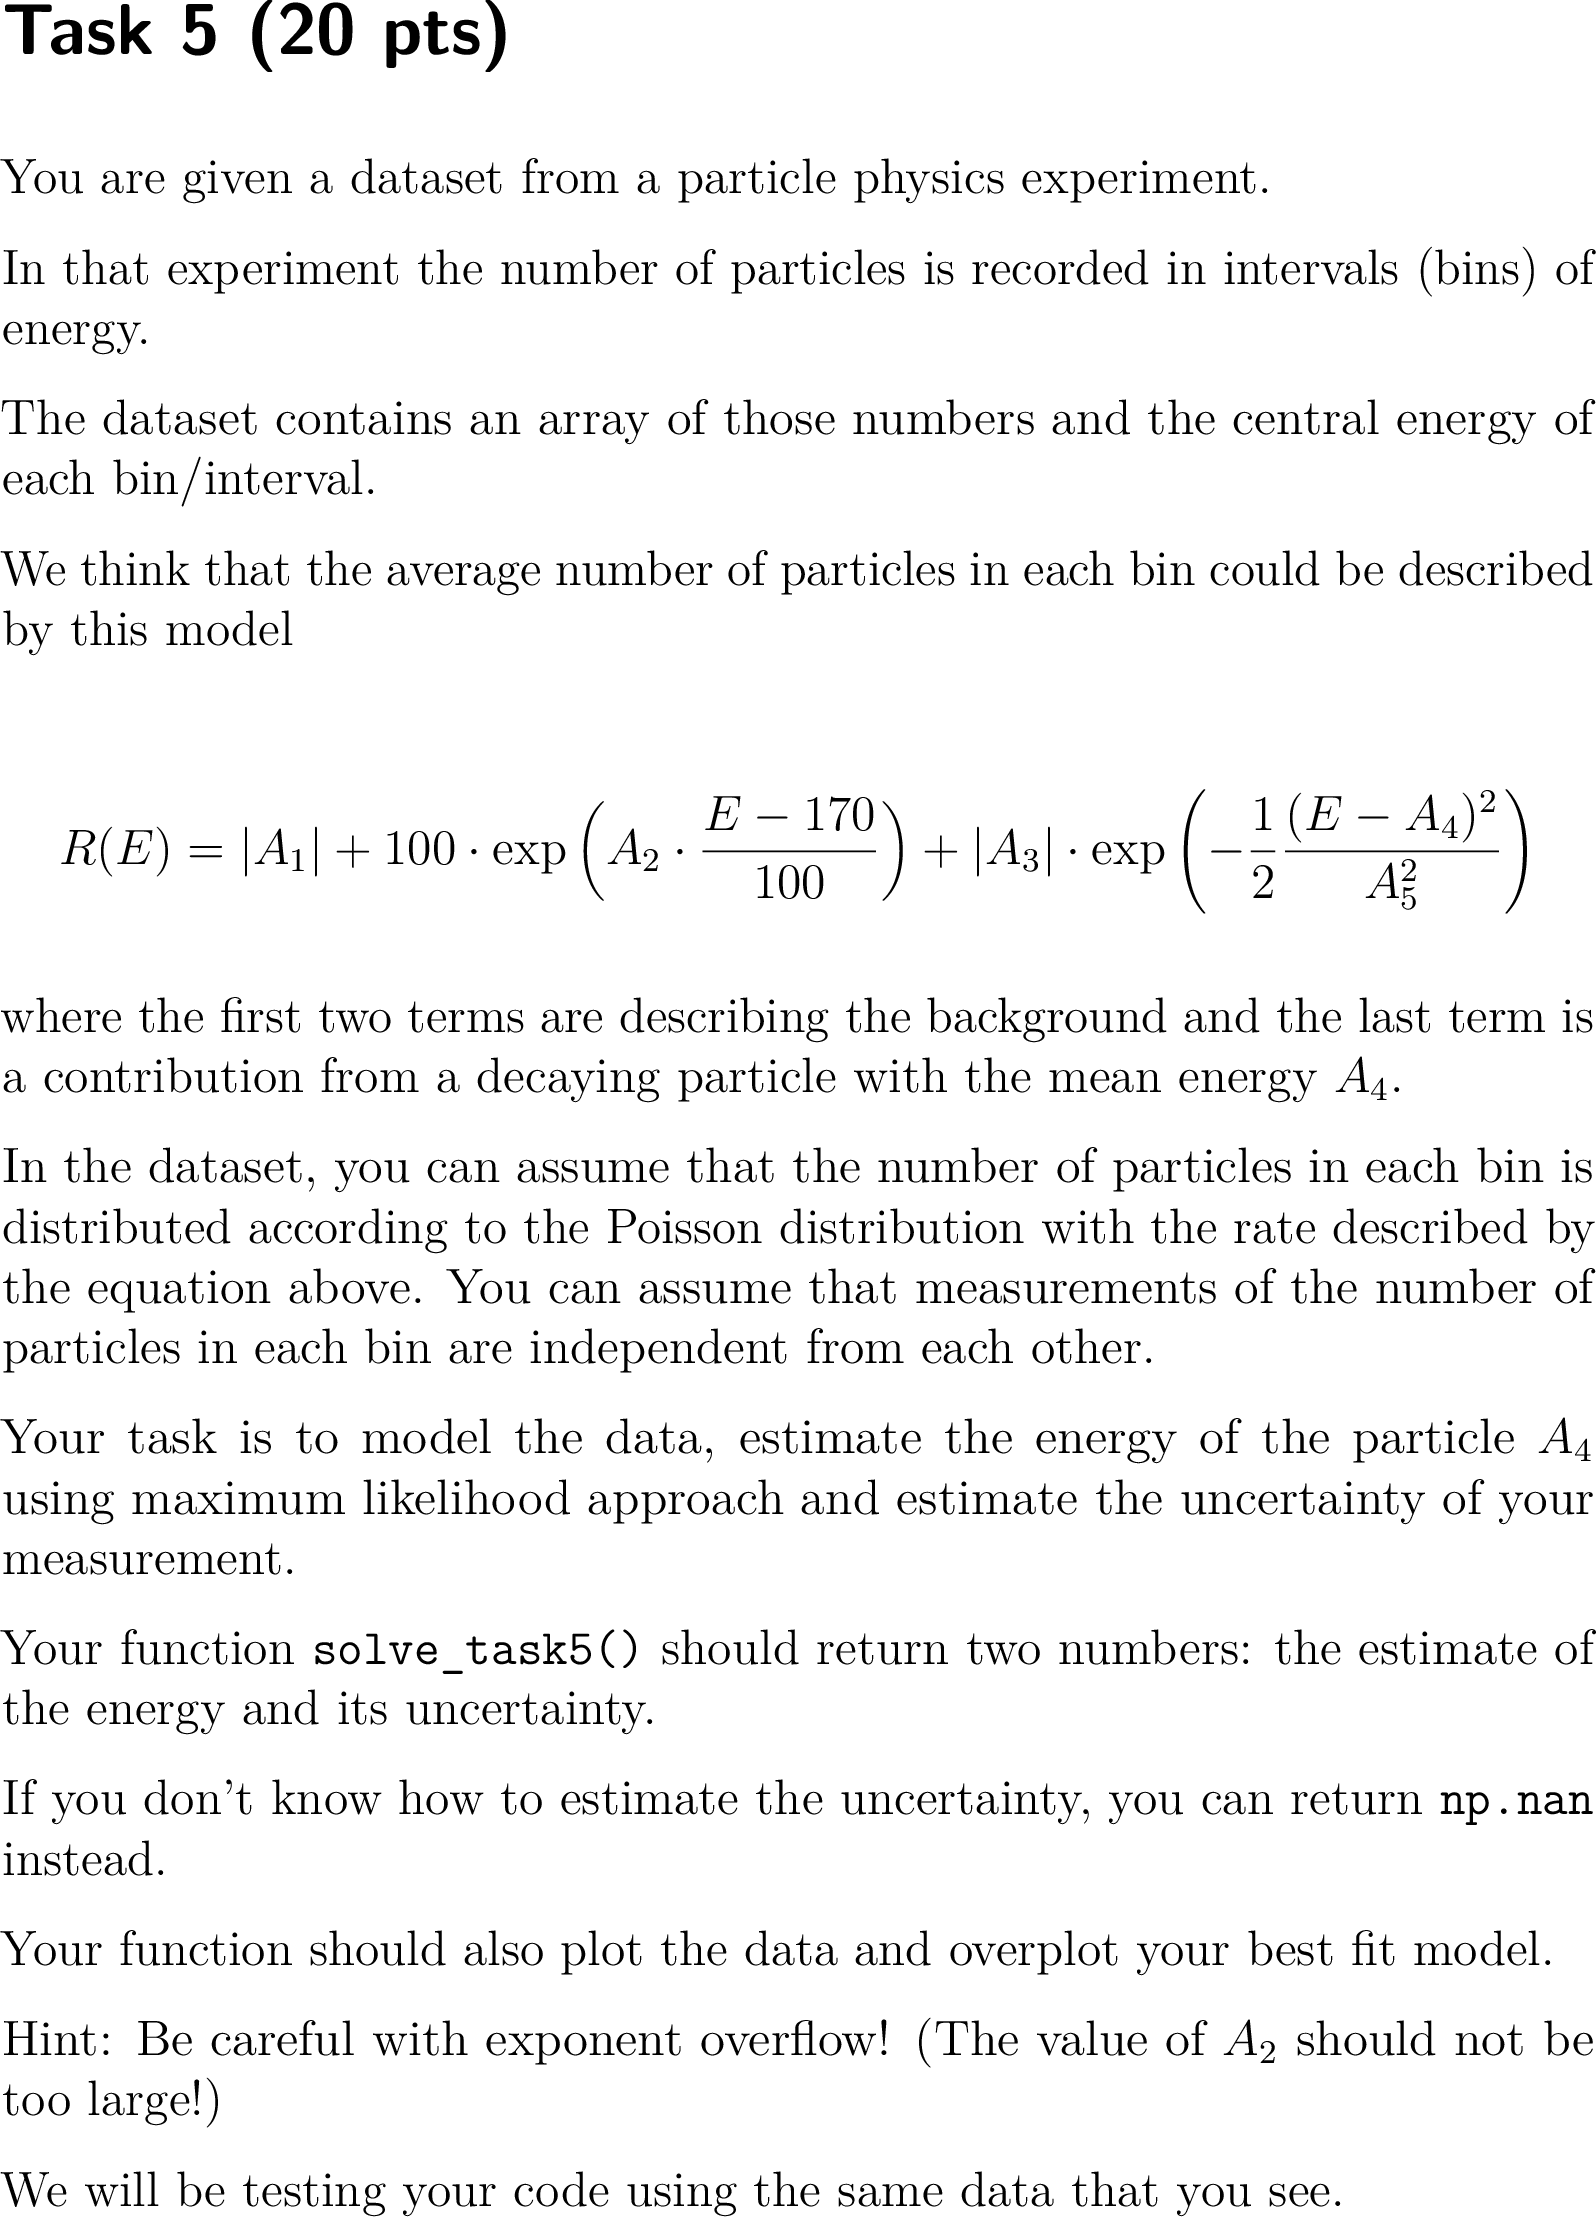

In [ ]:
def task5_data_reader(filename):
    # This simply reads the data and return the array of Energies and the number counts in each bin
    # Use this function to read the data
    # DO NOT CHANGE THIS
    D = np.loadtxt("checkpoint2_task5.txt", dtype=[("i", float), ("E", np.float64), ("N", float)])
    i = D["i"].astype(int)
    E, N = D["E"][i == UID % 100], D["N"][i == UID % 100].astype(int)
    return E, N


T5_E, T5_N = task5_data_reader("checkpoint2_task5.txt")
plt.plot(T5_E, T5_N, drawstyle="steps")
plt.xlabel("Energy")
plt.ylabel("Number of particles")

In [ ]:
def solve_task5(filename):
    """
    Returns the best value of A4 and its uncertainty.
    Plots the data and best fit model.
    """
    T5_E, T5_N = task5_data_reader(filename)
    
    def model_function(E, A1, A2, A3, A4, A5):
        return (np.abs(A1) +
                100 * np.exp(A2 * (E - 170) / 100) +
                np.abs(A3) * np.exp(-0.5 * ((E - A4) / A5)**2))
    
    def loglike(params):
        A1, A2, A3, A4, A5 = params
        rate = model_function(T5_E, A1, A2, A3, A4, A5) 
        
        # Using scipy.stats 
        logp = scipy.stats.poisson.logpmf(T5_N, rate)  
        loglike = logp.sum()
        
        if not np.isfinite(loglike):
            return 1e10
        
        # Equation from slides
        # logp = T5_N * np.log(rate) - rate   #ignoring factorial becasue constant wrt params
        # loglike = logp.sum()
        
        return -loglike
    
    # finding A4
    res = scipy.optimize.minimize(loglike, [10, 0.9, 100, 150, 140], method='Nelder-Mead')
    
    best_params = res.x
    
    # error calc using workshop code
    cov = numdifftools.Hessian(loglike)(best_params)
    err = np.sqrt(np.diag(scipy.linalg.inv(cov)))
    
    # Plotting section
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(T5_E, T5_N, label="Given Data", drawstyle="steps")
    
    Egrid = np.linspace(T5_E.min(), T5_E.max(), len(T5_E))
    ax.plot(Egrid, model_function(Egrid, *best_params), label="Fitted Data", color="r", drawstyle="steps")
            
    ax.set_xlabel("Energy")
    ax.set_ylabel("Number of particles")
    
    ax.legend()
    plt.show()
    
    print(f"Best Value for A4 is {best_params[3]} with error {err[3]}")
    
    return best_params[3], err[3]

In [ ]:
# This is how the function will be run

bestval, besterr = solve_task5("checkpoint2_task5.txt")